In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import linprog
from mpl_toolkits.mplot3d.art3d import Line3DCollection
from scipy.spatial import HalfspaceIntersection, ConvexHull
from itertools import combinations
import networkx as nx

## 4.3 Computing Nash equilibria of n-player, general-sum games

Given the exponential difficulty of calculating equilibria even for just 2 player games, it is unsuprising that optimisation is a tempting alternative. It also makes the problem significantly simpler! Say that the strategy of both players is encoded as a vector $s$. Then for any $s$ define $c_i^j(s)$ as the benefit that player $i$ gets from deviating to strategy $j$. I.e., $c_i^j(s)=u_i(a_i^j,s_{-i})-u_i(s)$. Remember at equilibrium no player wants to deviate from their strategy. We can then set a lower bound of 0 on this (as we don't want someone's huge positive to outweight another's negative), defining $d_i^j=\text{max}(c_i^j(s),0)$. Then we just need to optimise the sum of this function over all $i$ and $j$, subject to all weights being probabilities (non-negative & sum to 1). So, e.g.,

$$\text{minimise} \quad f(s) = \sum_i \sum_j (d_i^j(s))^2$$

Doing the square here makes the function differentiable everywhere ($|x|$ is not differentiable at 0).

Note that the equilibria will be at points where this function is 0.

To see an example, let's consider the matching-pennies problem:

$
\begin{array}{c|cc}
\text{} & \text{H} & \text{T} \\
\hline
\text{H} & 1,-1 & -1,1 \\
\text{T} & -1,1 & 1,-1 \\
\end{array}
$

This gives:

$
\begin{align*}
c_1^H &= [s_2^H-s_2^T] - [s_1^Hs_2^H-s_1^Ts_2^H-s_1^Hs_2^T+s_1^Ts_2^T] \\
c_1^T &= [s_2^T-s_2^H] - [s_1^Hs_2^H-s_1^Ts_2^H-s_1^Hs_2^T+s_1^Ts_2^T] \\
c_2^H &= [s_1^T-s_1^H] - [-s_1^Hs_2^H+s_1^Ts_2^H+s_1^Hs_2^T-s_1^Ts_2^T] \\
c_2^T &= [s_1^H-s_1^T] - [-s_1^Hs_2^H+s_1^Ts_2^H+s_1^Hs_2^T-s_1^Ts_2^T] \\
\end{align*}
$

Which can be simplified to:

$
\begin{align*}
c_1^H &= s_2^H[1 - s_1^H + s_1^T] - s_2^T[1 - s_1^H + s_1^T] \\
c_1^T &= s_2^H[-1 - s_1^H + s_1^T] - s_2^T[-1 - s_1^H + s_1^T] \\
c_2^H &= s_1^H[-1 + s_2^H - s_2^T] - s_1^T[-1 + s_2^H - s_2^T] \\
c_2^T &= s_1^H[1 + s_2^H - s_2^T] - s_1^T[1 + s_2^H - s_2^T] \\
\end{align*}
$

Which in turn is:

$
\begin{align*}
c_1^H &= (s_2^H - s_2^T)[1 - s_1^H + s_1^T] \\
c_1^T &= (s_2^H - s_2^T)[-1 - s_1^H + s_1^T] \\
c_2^H &= (s_1^H - s_1^T)[-1 + s_2^H - s_2^T] \\
c_2^T &= (s_1^H - s_1^T)[1 + s_2^H - s_2^T] \\
\end{align*}
$

And if (as we have done before) we just replace $s_1^T$ with $1-s_1^H$ and so on...

$
\begin{align*}
c_1^H &= (2s_2^H - 1)(2 - 2s_1^H) \\
c_1^T &= (2s_2^H - 1)(-2s_1^H) \\
c_2^H &= (2s_1^H - 1)(-2 + 2s_2^H) \\
c_2^T &= (2s_1^H - 1)(2s_2^H) \\
\end{align*}
$

And finally we can plot the objective function for $s_1^H$ and $s_2^H$:

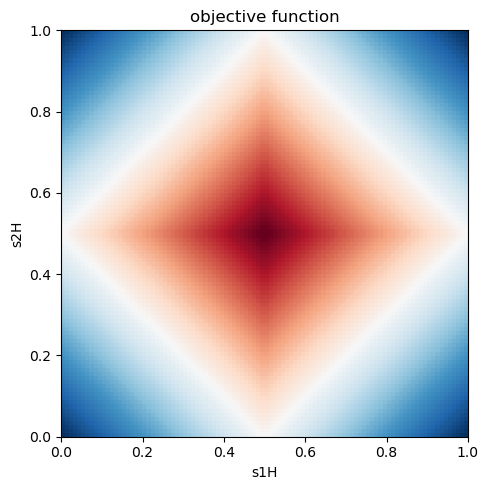

In [3]:
def objective_function(s1H,s2H):
    c1H = (2*s2H-1)*(2-2*s1H)
    c1T = (2*s2H-1)*(-2*s1H)
    c2H = (2*s1H-1)*(-2+2*s2H)
    c2T = (2*s1H-1)*(2*s2H)
    return c1H*(c1H>0)+c1T*(c1T>0)+c2H*(c2H>0)+c2T*(c2T>0)

objective_at_grid = np.zeros((100,100))
for row,s1H in enumerate(np.linspace(0,1,100)):
    for col,s2H in enumerate(np.linspace(0,1,100)):
        objective_at_grid[row,col]=objective_function(s1H,s2H)


plt.figure(figsize=(5,5))
plt.imshow(objective_at_grid, extent=[0, 1, 0, 1], origin='lower', cmap='RdBu', aspect='equal')
plt.title("objective function",fontsize=12)
plt.xlabel("s1H",fontsize=10)
plt.ylabel("s2H",fontsize=10)
plt.tight_layout()
plt.show()

The only equilibrium is unsuprisingly in the center, which has a value of 0.

Constrained optimisation is sometimes more difficult that unconstrained optimisation, so to change the former to the latter we can integrate the probability restrictions into this formula too:

$$\text{minimise} \quad f(s) = \sum_i \sum_j (d_i^j(s))^2 + \sum_i (1 - \sum_j s_i^j)^2 + \sum_i \sum_j (\text{min}(s_j^i,0))^2$$

The downside of these optimisation approaches is that there might be local minima which are not 0 and hence not equilibria.

Other approaches are to use a coarse-to-fine method or the SEM algorithm.

## 4.4 Computing maxmin and minmax strategies for two-player games

Computing the maxmin and minmax strategies is thanksfully pretty simple. Recall that a minmax strategy for player 1 is an action that maximises the return to player 1, given that player 2 has a strategy which minimises the maximum return to player 1. Recall from before:

$$
\begin{align*}
\text{minimise} \quad & v_1 \\
\text{subject to} \quad & \sum_{k} U_1(A_1^j,A_2^k)s_2^k \leq v_1 \quad \forall A_1^j \\
\text{} \quad & \sum_{k} s_2^k=1 \\
\text{} \quad & s_2^k\geq 0 \\
\end{align*}
$$

Essentially we learn a strategy for player 2 that minimises the best return for player 1. (After doing this player 1's strategy is trivial). Notice that the above doesn't depend on $U_2$. So, the minmax strategy of player 1 won't change no matter how we alter the utility for player 2. 

So, to get the minmax strategy of a general-sum game we can define a zero-sum game in which player 1 has the same utility $U_1$, but player 2's utility is replaced with $-U_1$. This new game is zero-sum, and because changing the utility of player 2 has no impact on the minmax strategy we can pull any minmax strategy found in the zero-sum version of the game through to the original general-sum version.

Consider this problem:

$
\begin{array}{c|cc}
\text{} & \text{X} & \text{Y} & \text{Z} \\
\hline
\text{X} & 4,2 & 2,1 & 0,0\\
\text{Y} & 1,0 & 3,3 & 1,0\\
\end{array}
$

The game is clearly not zero-sum. There are at least 2 equilibria, at XX and YY. 

If player 2 minimises the maximum that player 1 can get they will play the pure strategy $Z$. Given that, player 1's minmax strategy will be $Y$.

If player 1 minimises the maximum that player 2 can get they will play $X$ with probability $\frac{3}{4}$:

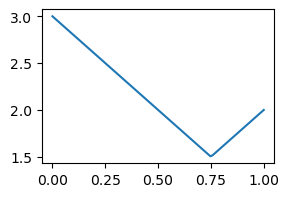

In [4]:
s1 = np.linspace(0,1,100)
r2X = 2*s1+0*(1-s1)
r2Y = 1*s1+3*(1-s1)
r2Z = 0*s1+0*(1-s1)
plt.figure(figsize=(3,2))
plt.plot(s1,np.maximum(r2X,r2Y,r2Z))
plt.show()

This means the minmax strategy for player 2 is to go either $X$ or $Y$, it doesn't matter. 